In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson,binom
import seaborn as sns

In [10]:
# Question 1
data = pd.read_csv('soccer17.csv')
data.loc[:,'GameID'] = data.index
data17all = data.loc[(data.Y == 17)]

# Adding columns to calculate home team goal differential in each game (Home Goals - Away Goals)
data17all.loc[:,'HomeGDiff'] = data17all.loc[:,'FTHG'] - data17all.loc[:,'FTAG']
data17all.loc[:,'AwayGDiff'] = data17all.loc[:,'FTAG'] - data17all.loc[:,'FTHG']

In [11]:
# Splitting each game into two rows and identifying home team
datamelt = pd.melt(data17all, id_vars = ['GameID', 'Date', 'Div'], value_vars = ['HomeTeam','AwayTeam'], var_name = 'isHome', value_name = 'Team')
datamelt.loc[:,'isHome'] = 1*(datamelt.isHome == 'HomeTeam')
datamelt.sample(5)

,GameID,Date,Div,isHome,Team
3331,6981,2017-10-25,Serie_A,0,Benevento
2907,5417,2017-08-26,Ligue_1,0,Lyon
3326,6976,2017-10-22,Serie_A,0,Roma
2595,3966,2017-09-16,Bundesliga,0,Augsburg
3564,7214,2018-04-18,Serie_A,0,Genoa


In [12]:
# Identifying goal differential of each team 
datamelt2 = pd.melt(data17all, id_vars = ['GameID'], value_vars = ['HomeGDiff','AwayGDiff'], var_name = 'isHome', value_name = 'GDiff')
datamelt2.loc[:,'isHome'] = 1*(datamelt2.isHome == 'HomeGDiff')
datamelt2.sample(5)

,GameID,isHome,GDiff
1026,4223,1,3
2620,3991,0,0
48,1187,1,0
956,4153,1,0
925,4122,1,-1


In [13]:
# Merging above melts into one
datamelt = datamelt.merge(datamelt2, on = ['GameID', 'isHome'])
datamelt = datamelt.sort_values(['Date','GameID'])
datamelt.sample(5)

,GameID,Date,Div,isHome,Team,GDiff
554,2833,2018-01-07,La_Liga,1,Leganes,1
591,2870,2018-02-04,La_Liga,1,Espanol,0
637,2916,2018-03-03,La_Liga,1,Leganes,2
1346,5682,2018-04-01,Ligue_1,1,Lille,-1
925,4122,2018-02-03,Bundesliga,1,Schalke 04,-1


In [15]:
# Making new dataframe including games played, avg goal differential, wins, losses, and draws for each team
# GDiff calculated by averaging total differentials for each team through a groupby
# Wins, losses, draws calculated using goal differential distance to 0
goaldiff = datamelt['GDiff'].groupby([datamelt['Div'], datamelt['Team']]).mean().reset_index()

stats = pd.DataFrame({'Wins':datamelt[datamelt['GDiff'] > 0]['GDiff'].groupby(datamelt['Team']).count(),
                  'Losses':datamelt[datamelt['GDiff'] < 0]['GDiff'].groupby(datamelt['Team']).count(),
                  'Draws':datamelt[datamelt['GDiff'] == 0]['GDiff'].groupby(datamelt['Team']).count()}).reset_index()

goaldiff = goaldiff.merge(stats)

# GamesPlayed calculated by simple sum of win, loss, draw columns
# Points calculated as 3*Wins + 1*Draw for each team
goaldiff.loc[:,'GamesPlayed'] = goaldiff.loc[:,'Wins'] + goaldiff.loc[:,'Losses'] + goaldiff.loc[:,'Draws']
goaldiff.insert(7, 'Points', goaldiff.loc[:,'Wins']*3 + goaldiff.loc[:,'Draws']*1)
goaldiff

,Div,Team,GDiff,Wins,Losses,Draws,GamesPlayed,Points
0,Bundesliga,Augsburg,-0.088235,10,13,11,34,41
1,Bundesliga,Bayern Munich,1.882353,27,4,3,34,84
2,Bundesliga,Dortmund,0.500000,15,9,10,34,55
3,Bundesliga,Ein Frankfurt,0.000000,14,13,7,34,49
4,Bundesliga,FC Koln,-1.029412,5,22,7,34,22
...,...,...,...,...,...,...,...,...
93,Serie_A,Sassuolo,-0.789474,11,17,10,38,43
94,Serie_A,Spal,-0.526316,8,16,14,38,38
95,Serie_A,Torino,0.210526,13,10,15,38,54
96,Serie_A,Udinese,-0.394737,12,22,4,38,40


In [17]:
# 1a
data17epl = goaldiff[goaldiff['Div'] == 'EPL'].sort_values(by=['GDiff'], ascending = False).drop(['Div','Points'], axis = 1)
data17epl

,Team,GDiff,Wins,Losses,Draws,GamesPlayed
28,Man City,2.078947,32,2,4,38
27,Liverpool,1.210526,21,5,12,38
29,Man United,1.052632,25,7,6,38
34,Tottenham,1.000000,23,7,8,38
22,Chelsea,0.631579,21,10,7,38
18,Arsenal,0.605263,19,13,6,38
21,Burnley,-0.078947,14,12,12,38
26,Leicester,-0.105263,12,15,11,38
30,Newcastle,-0.210526,12,18,8,38
23,Crystal Palace,-0.263158,11,16,11,38


In [18]:
# 1b
data17epl = goaldiff[goaldiff['Div'] == 'EPL'].sort_values(by=['Points'], ascending = False).drop(['Div'], axis = 1)
data17epl

,Team,GDiff,Wins,Losses,Draws,GamesPlayed,Points
28,Man City,2.078947,32,2,4,38,100
29,Man United,1.052632,25,7,6,38,81
34,Tottenham,1.000000,23,7,8,38,77
27,Liverpool,1.210526,21,5,12,38,75
22,Chelsea,0.631579,21,10,7,38,70
18,Arsenal,0.605263,19,13,6,38,63
21,Burnley,-0.078947,14,12,12,38,54
24,Everton,-0.368421,13,15,10,38,49
26,Leicester,-0.105263,12,15,11,38,47
23,Crystal Palace,-0.263158,11,16,11,38,44


In [33]:
# 1c
data17top = goaldiff.groupby('Div')['GDiff'].nlargest(3).reset_index()
data17top = data17top.merge(goaldiff, on = ['Div', 'GDiff']).drop('level_1', axis = 1)
data17top

,Div,GDiff,Team,Wins,Losses,Draws,GamesPlayed,Points
0,Bundesliga,1.882353,Bayern Munich,27,4,3,34,84
1,Bundesliga,0.529412,Hoffenheim,15,9,10,34,55
2,Bundesliga,0.500000,Dortmund,15,9,10,34,55
3,EPL,2.078947,Man City,32,2,4,38,100
4,EPL,1.210526,Liverpool,21,5,12,38,75
5,EPL,1.052632,Man United,25,7,6,38,81
6,La_Liga,1.842105,Barcelona,28,1,9,38,93
7,La_Liga,1.315789,Real Madrid,22,6,10,38,76
8,La_Liga,0.947368,Ath Madrid,23,5,10,38,79
9,Ligue_1,2.078947,Paris SG,29,3,6,38,93


In [211]:
# Question 2
# We will use a poisson distribution with lambda parameter equal to the mean of the total goals per game
# Making new column TGFT (Total Goals Full Time) by summing FTHG and FTAG for each game
data.loc[:,'TGFT'] = data.loc[:,'FTHG'] + data.loc[:,'FTAG']
print(f'lambda parameter for poisson distribution = {data.TGFT.mean()}')

lambda parameter for poisson distribution = 2.710158817086528


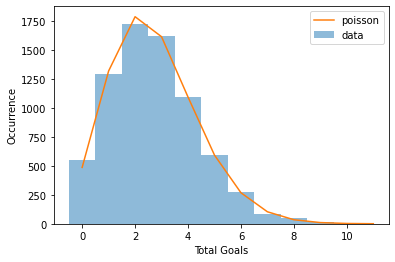

In [212]:
# 2a
bins = range(12)
plt.hist(data.TGFT, bins, alpha=0.5, label = 'data', align = 'left')
plt.plot(bins, poisson.pmf(bins, data.TGFT.mean())*len(data), label='poisson')
plt.legend(loc='upper right'), plt.xlabel('Total Goals'), plt.ylabel('Occurrence')
plt.show()

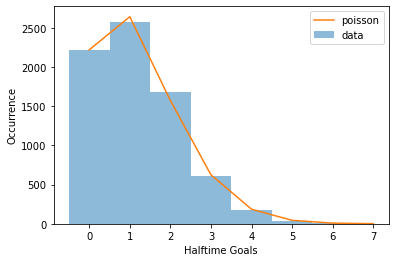

In [214]:
# 2b
data.loc[:,'TGHT'] = data.loc[:,'HTHG'] + data.loc[:,'HTAG']
bins = range(8)
plt.hist(data.TGHT, bins, alpha=0.5, label = 'data', align = 'left')
plt.plot(bins, poisson.pmf(bins, data.TGHT.mean())*len(data), label='poisson')
plt.legend(loc='upper right'), plt.xlabel('Halftime Goals'), plt.ylabel('Occurrence')
plt.show()

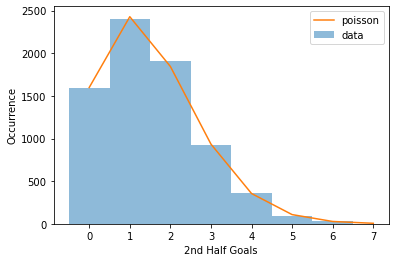

In [215]:
# 2c
data.loc[:,'TG2H'] = (data.loc[:,'FTHG'] - data.loc[:,'HTHG']) + (data.loc[:,'FTAG'] - data.loc[:,'HTAG'])
bins = range(8)
plt.hist(data.TG2H, bins, alpha=0.5, label = 'data', align = 'left')
plt.plot(bins, poisson.pmf(bins, data.TG2H.mean())*len(data), label='poisson')
plt.legend(loc='upper right'), plt.xlabel('2nd Half Goals'), plt.ylabel('Occurrence')
plt.show()

In [133]:
# 2d
goalavg = data.groupby('Div')['TGFT'].mean().reset_index()
goalavg.insert(2, 'GamesPlayed', [34,38,38,38,38])
goalavg.sort_values(by = 'TGFT', ascending = False)

,Div,TGFT,GamesPlayed
0,Bundesliga,2.811275,34
2,La_Liga,2.759211,38
4,Serie_A,2.725658,38
1,EPL,2.686184,38
3,Ligue_1,2.588158,38


In [218]:
# 2d
goalavg = data.groupby('Div')['TGFT'].mean().reset_index()
goalavg = goalavg.merge(pd.DataFrame({'GamesPlayed': data.groupby('Div')['TGFT'].count()}).reset_index())
goalavg.sort_values(by = 'TGFT', ascending = False)

,Div,TGFT,GamesPlayed
0,Bundesliga,2.811275,1224
2,La_Liga,2.759211,1520
4,Serie_A,2.725658,1520
1,EPL,2.686184,1520
3,Ligue_1,2.588158,1520


In [145]:
# 2e
fourgoals = data[(data['TGFT'] == 4) & (abs(data['pH'] - data['pA']) < 0.04)]
draws = fourgoals[fourgoals['FTHG'] == fourgoals['FTAG']]

In [185]:
# In 4 goal games, we would expect draws 37.5% of the time
probdraw = binom.pmf(2,4,0.5)
sig = np.sqrt(len(fourgoals)*probdraw*(1-probdraw))
std = (len(draws) - len(fourgoals)*probdraw)/sig

In [194]:
std

2.439750182371331

In [233]:
from scipy import stats
res = [1]*len(draws) + [0]*int(np.round((len(fourgoals)*probdraw)))
stats.ttest_1samp(res,0.375)

Ttest_1sampResult(statistic=3.0911806364676795, pvalue=0.0031043972452001974)